# -- START: Techical Requirements --

In [1]:
import matplotlib 
import pandas as pd
import scipy 
import statsmodels

print(f'''
Matplotlib -> {matplotlib.__version__}
pandas -> {pd.__version__}   
scipy -> {scipy.__version__}
statsmodels -> {statsmodels.__version__}
''')


Matplotlib -> 3.5.1
pandas -> 1.4.1   
scipy -> 1.7.3
statsmodels -> 0.14.0.dev400+gebf934b9c



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


import warnings


warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = [16, 3]

In [3]:
###### configurations for image quality#######
plt.rcParams["figure.figsize"] = [12, 5]   ##
# plt.rcParams['figure.dpi'] = 300           ## 300 for printing
plt.rc('font', size=8)                     ## 
plt.rc('axes', titlesize=16)               ## 
plt.rc('axes', labelsize=14)               ##
plt.rc('xtick', labelsize=10)              ##
plt.rc('ytick', labelsize=10)              ##
plt.rc('legend', fontsize=10)              ##
plt.rc('figure', titlesize=12)             ## 
#############################################

### Create DataFrames 

In [4]:
file = Path("../../datasets/Ch14/nyc_taxi.csv")

nyc_taxi = pd.read_csv(file, 
                     index_col='timestamp', 
                     parse_dates=True)

In [5]:
def plot_outliers(outliers, data, method='KNN',
                 halignment = 'right', 
                 valignment = 'top',
                 labels=False,
                 name=None):

    ax = data.plot(alpha=0.6)
    
    if labels:
        for i in outliers['value'].items():
            plt.plot(i[0], i[1], 'v', markersize=8, markerfacecolor='none', markeredgecolor='k')
            plt.text(i[0], i[1]-(i[1]*0.04), f'{i[0].strftime("%m/%d")}', 
                         horizontalalignment=halignment,
                         verticalalignment=valignment)
    else:
        data.loc[outliers.index].plot(ax=ax, style='rX', markersize=9)
        
    plt.title(f'NYC Taxi - {method}')
    plt.xlabel('date'); plt.ylabel('Number of passengers')
    plt.legend(['nyc taxi','outliers'])
    if name:
        plt.savefig(f'../../../Packt-Time-Series-Cookbook/Chapters/Ch14/images/{name}.png', bbox_inches='tight', dpi=600)
    plt.show()

### Visualize DataFrames

In [6]:
nyc_taxi.index

DatetimeIndex(['2014-07-01 00:00:00', '2014-07-01 00:30:00',
               '2014-07-01 01:00:00', '2014-07-01 01:30:00',
               '2014-07-01 02:00:00', '2014-07-01 02:30:00',
               '2014-07-01 03:00:00', '2014-07-01 03:30:00',
               '2014-07-01 04:00:00', '2014-07-01 04:30:00',
               ...
               '2015-01-31 19:00:00', '2015-01-31 19:30:00',
               '2015-01-31 20:00:00', '2015-01-31 20:30:00',
               '2015-01-31 21:00:00', '2015-01-31 21:30:00',
               '2015-01-31 22:00:00', '2015-01-31 22:30:00',
               '2015-01-31 23:00:00', '2015-01-31 23:30:00'],
              dtype='datetime64[ns]', name='timestamp', length=10320, freq=None)

In [9]:
nyc_dates =  [
        "2014-11-01",
        "2014-11-27",
        "2014-12-25",
        "2015-01-01",
        "2015-01-27"
]
tx = nyc_taxi.resample('D').mean()
known_outliers = tx.loc[nyc_dates]

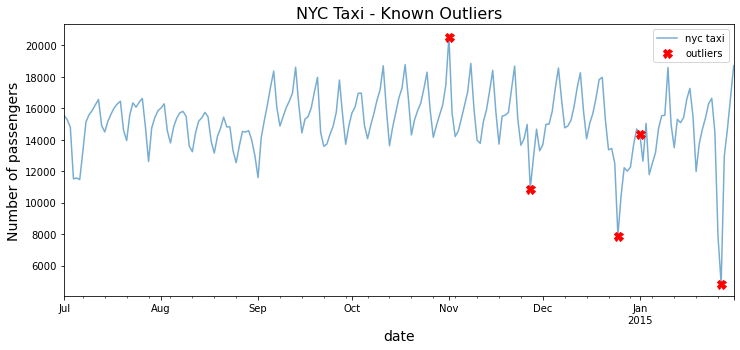

In [10]:
plot_outliers(known_outliers, tx, 'Known Outliers', name='fig14.1')

# Detecting Outliers using K-Nearest Neighbors

In [16]:
from pyod.models.knn import KNN

In [17]:
# !conda list pyod

In [18]:
knn = KNN(contamination=0.03,
          method='mean',
          n_neighbors=5)

In [19]:
knn.fit(tx)

KNN(algorithm='auto', contamination=0.03, leaf_size=30, method='mean',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)

In [20]:
predicted = pd.Series(knn.predict(tx), 
                      index=tx.index)

In [21]:
print('Number of outliers = ', predicted.sum())

Number of outliers =  6


In [22]:
tx.loc[nyc_dates]

,value
timestamp,
2014-11-01,20553.500000
2014-11-27,10899.666667
2014-12-25,7902.125000
2015-01-01,14383.479167
2015-01-27,4834.541667


In [23]:
outliers = predicted[predicted == 1]
outliers = tx.loc[outliers.index] 
outliers

,value
timestamp,
2014-11-01,20553.500000
2014-11-27,10899.666667
2014-12-25,7902.125000
2014-12-26,10397.958333
2015-01-26,7818.979167
2015-01-27,4834.541667


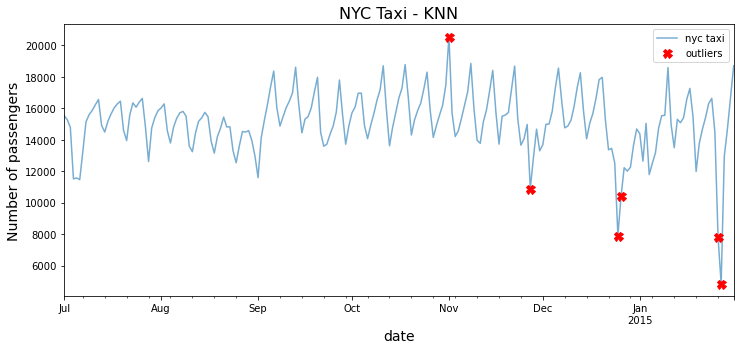

In [24]:
plot_outliers(outliers, tx, 'KNN',  name='fig14.2')

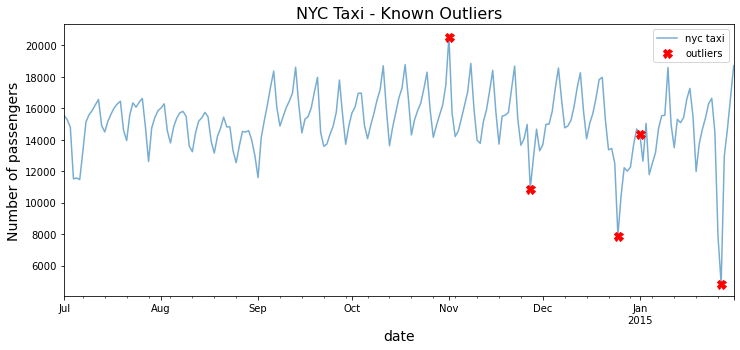

In [25]:
plot_outliers(known_outliers, tx, 'Known Outliers')

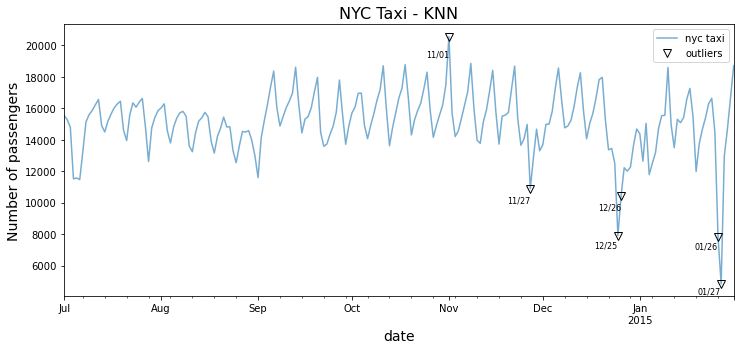

In [26]:
plot_outliers(outliers, 
              tx, 
              'KNN',
              labels=True)

## How it works

In [73]:
knn_scores = knn.decision_scores_
knn_scores_df = (pd.DataFrame(knn_scores, 
             index=tx.index, 
             columns=['score']))

knn_scores_df[knn_scores_df['score'] >= knn.threshold_].sort_values('score', ascending=False)

,score
timestamp,
2015-01-27,4862.058333
2015-01-26,2474.508333
2014-12-25,2441.250000
2014-11-01,1806.850000
2014-12-26,1009.616667
2014-11-27,608.250000
2014-09-27,225.604167


In [420]:
n = int(len(tx)*0.03)
knn_scores_df.nlargest(n, 'score')

,score
timestamp,
2015-01-27,4862.058333
2015-01-26,2474.508333
2014-12-25,2441.250000
2014-11-01,1806.850000
2014-12-26,1009.616667
2014-11-27,608.250000


In [428]:
knn_scores_df.min()

score    11.745833
dtype: float64

In [429]:
knn_scores_df.max()

score    4862.058333
dtype: float64

In [431]:
(2474.508333 - 11.745833)*100/(4862.058333-11.745833)

50.77533664068037

In [445]:
knn_proba = knn.predict_proba(tx, method='linear')
knn_proba_df = (pd.DataFrame(np.round(knn_proba * 100, 3),
            index=tx.index,
            columns=['Proba_Normal', 'Proba_Anomaly']))
knn_proba_df.nlargest(n, 'Proba_Anomaly')

,Proba_Normal,Proba_Anomaly
timestamp,,
2015-01-27,27.337,72.663
2015-01-26,64.256,35.744
2014-12-25,64.599,35.401
2014-11-01,70.682,29.318
2014-12-26,84.341,15.659
2014-11-27,90.548,9.452


In [444]:
knn_proba = knn.predict_proba(tx, method='unify')
knn_proba_df = (pd.DataFrame(np.round(knn_proba * 100, 3),
            index=tx.index,
            columns=['Proba_Normal', 'Proba_Anomaly']))
knn_proba_df.nlargest(n, 'Proba_Anomaly')

,Proba_Normal,Proba_Anomaly
timestamp,,
2015-01-27,0.000,100.000
2015-01-26,0.012,99.988
2014-12-25,0.014,99.986
2014-11-01,0.189,99.811
2014-12-26,12.225,87.775
2014-11-27,40.330,59.670


In [135]:
from joblib import dump, load

# save the model
dump(knn, 'knn_outliers.joblib')
# load the model
knn = load('knn_outliers.joblib')

In [136]:
knn

KNN(algorithm='auto', contamination=0.03, leaf_size=30, method='mean',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)

## There is more

In [360]:
from pyod.utils.utility import standardizer
scaled = standardizer(tx)
predicted = pd.Series(knn.fit_predict(scaled), 
                      index=tx.index)
outliers_scaled = predicted[predicted == 1]
outliers_scaled = tx.loc[outliers.index] 
outliers_scaled

,value
timestamp,
2014-11-01,20553.500000
2014-11-27,10899.666667
2014-12-25,7902.125000
2014-12-26,10397.958333
2015-01-26,7818.979167
2015-01-27,4834.541667


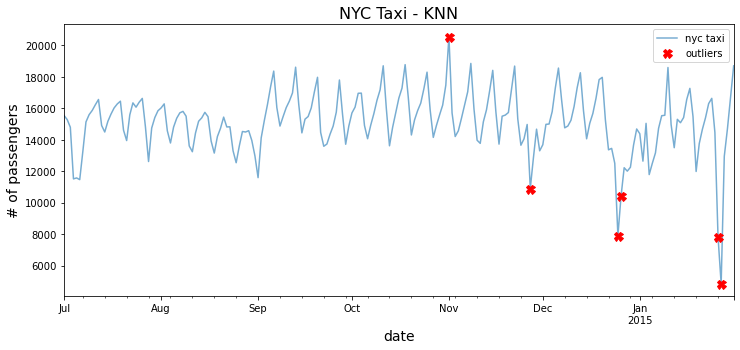

In [361]:
plot_outliers(outliers, tx, 'KNN')

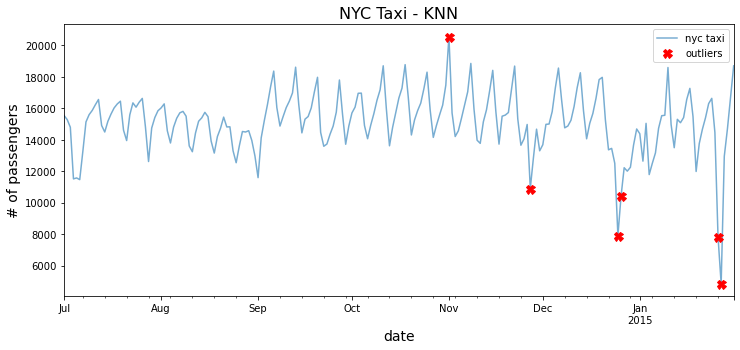

In [362]:
plot_outliers(outliers_scaled, tx, 'KNN')

In [480]:
def knn_anomaly(df, method='mean', contamination=0.05, k=5):
    knn = KNN(contamination=contamination,
              method=method,
              n_neighbors=5)
    knn.fit(df)
    
    decision_score = pd.DataFrame(knn.decision_scores_, 
                          index=df.index, columns=['score'])
    n = int(len(df)*contamination)
    outliers = decision_score.nlargest(n, 'score')
    return outliers, knn.threshold_

In [482]:
for method in ['mean', 'median', 'largest']:
    o, t = knn_anomaly(tx, method=method)
    print(f'Method= {method}, Threshold= {t}')
    print(o)


Method= mean, Threshold= 220.32916666666603
                  score
timestamp              
2015-01-27  4862.058333
2015-01-26  2474.508333
2014-12-25  2441.250000
2014-11-01  1806.850000
2014-12-26  1009.616667
2014-11-27   608.250000
2014-09-27   225.604167
2014-07-06   224.208333
2014-12-28   223.562500
2015-01-19   223.562500
Method= median, Threshold= 211.64999999999995
                  score
timestamp              
2015-01-27  5563.416667
2014-12-25  2997.541667
2015-01-26  2984.437500
2014-11-01  1847.083333
2014-12-26  1113.812500
2014-11-27   612.104167
2014-12-29   251.520833
2014-12-27   238.062500
2015-01-19   238.062500
2014-12-28   219.145833
Method= largest, Threshold= 411.85624999999993
                  score
timestamp              
2015-01-27  6629.729167
2015-01-26  3645.291667
2014-12-25  3562.145833
2014-11-01  1865.437500
2014-12-26  1191.916667
2014-11-27   690.208333
2014-07-06   518.583333
2014-07-04   471.083333
2014-12-19   436.604167
2014-09-27   431.750000

# Detecting Outliers Using Local Outlier Factor LOF

In [27]:
from pyod.models.lof import LOF

In [28]:
lof = LOF(contamination=0.03, n_neighbors=5)

In [29]:
lof.fit(tx)

LOF(algorithm='auto', contamination=0.03, leaf_size=30, metric='minkowski',
  metric_params=None, n_jobs=1, n_neighbors=5, novelty=True, p=2)

In [30]:
predicted = pd.Series(lof.predict(tx), 
                      index=tx.index)

In [31]:
print('Number of outliers = ', predicted.sum())

Number of outliers =  6


In [32]:
tx.loc[nyc_dates]

,value
timestamp,
2014-11-01,20553.500000
2014-11-27,10899.666667
2014-12-25,7902.125000
2015-01-01,14383.479167
2015-01-27,4834.541667


In [33]:
tx.shape

(215, 1)

In [34]:
outliers = predicted[predicted == 1]
outliers = tx.loc[outliers.index] 
outliers

,value
timestamp,
2014-10-31,17473.354167
2014-11-01,20553.500000
2014-12-25,7902.125000
2014-12-26,10397.958333
2015-01-26,7818.979167
2015-01-27,4834.541667


In [35]:
lof.threshold_

1.7717390813973128

In [36]:
lof_scores = lof.decision_scores_
lof_scores_df = (pd.DataFrame(lof_scores, 
             index=tx.index, 
             columns=['score']))
lof_scores_df[lof_scores_df['score'] >= lof.threshold_].sort_values('score', ascending=False)

,score
timestamp,
2014-11-01,14.254309
2015-01-27,5.270860
2015-01-26,3.988552
2014-12-25,3.952827
2014-12-26,2.295987
2014-10-31,2.158571
2015-01-12,1.796124


In [37]:
n = int(len(tx)*0.03)
lof_scores_df.nlargest(n, 'score')

,score
timestamp,
2014-11-01,14.254309
2015-01-27,5.270860
2015-01-26,3.988552
2014-12-25,3.952827
2014-12-26,2.295987
2014-10-31,2.158571


In [38]:
lof_proba = lof.predict_proba(tx, method='linear')
lof_proba_df = (pd.DataFrame(np.round(lof_proba * 100, 3),
            index=tx.index,
            columns=['Proba_Normal', 'Proba_Anomaly'])
            .sort_values('Proba_Anomaly',
                        ascending=False)
               )
lof_proba_df[:n].sort_index()

,Proba_Normal,Proba_Anomaly
timestamp,,
2014-10-31,92.361,7.639
2014-11-01,22.033,77.967
2014-12-25,89.121,10.879
2014-12-26,91.625,8.375
2015-01-26,88.972,11.028
2015-01-27,83.610,16.390


In [39]:
lof_proba = lof.predict_proba(tx, method='unify')
lof_proba_df = (pd.DataFrame(np.round(lof_proba * 100, 3),
            index=tx.index,
            columns=['Proba_Normal', 'Proba_Anomaly'])
            .sort_values('Proba_Anomaly',
                        ascending=False)
               )
lof_proba_df[:n].sort_index()

,Proba_Normal,Proba_Anomaly
timestamp,,
2014-10-31,47.955,52.045
2014-11-01,0.000,100.000
2014-12-25,25.309,74.691
2014-12-26,42.020,57.980
2015-01-26,24.484,75.516
2015-01-27,5.954,94.046


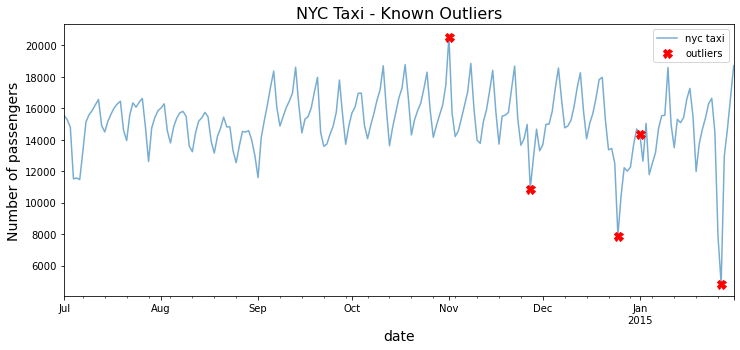

In [40]:
plot_outliers(known_outliers, tx, 'Known Outliers')

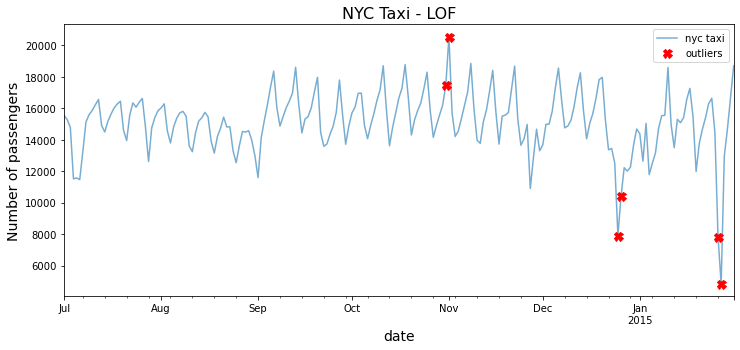

In [41]:
plot_outliers(outliers, tx, 'LOF', name='fig14.4')

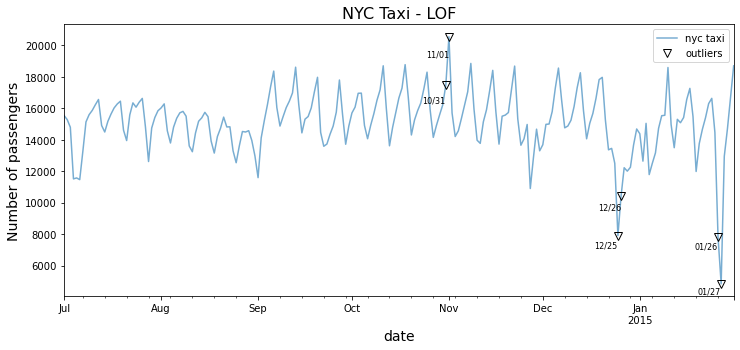

In [42]:
plot_outliers(outliers, tx, 'LOF', labels=True)

## There is more

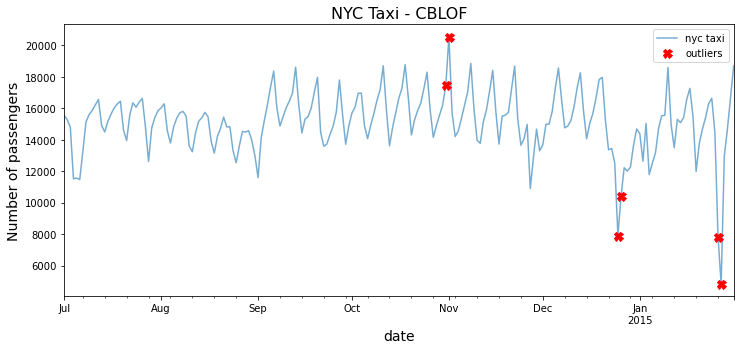

In [43]:
from pyod.models.cblof import CBLOF
cblof = CBLOF(n_clusters=4, contamination=0.03)
cblof.fit(tx)
predicted = pd.Series(lof.predict(tx), 
                      index=tx.index)
outliers = predicted[predicted == 1]
outliers = tx.loc[outliers.index] 
plot_outliers(outliers, tx, 'CBLOF', name='fig14.5')

# Detecting Outliers using Isolation Forests

In [44]:
from pyod.models.iforest import IForest

In [45]:
iforest = IForest(contamination=0.03,
                 n_estimators=100)
iforest.fit(tx)

IForest(behaviour='old', bootstrap=False, contamination=0.03,
    max_features=1.0, max_samples='auto', n_estimators=100, n_jobs=1,
    random_state=None, verbose=0)

In [46]:
predicted = pd.Series(iforest.predict(tx), 
                      index=tx.index)

In [47]:
print('Number of outliers = ', predicted.sum())

Number of outliers =  7


In [48]:
outliers = predicted[predicted == 1]
outliers = tx.loc[outliers.index] 
outliers

,value
timestamp,
2014-11-01,20553.500000
2014-11-08,18857.333333
2014-11-27,10899.666667
2014-12-25,7902.125000
2014-12-26,10397.958333
2015-01-26,7818.979167
2015-01-27,4834.541667


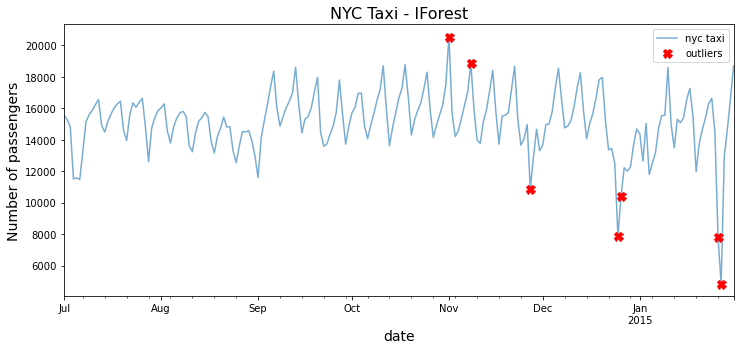

In [49]:
plot_outliers(outliers, tx, 'IForest', name='fig14.6')

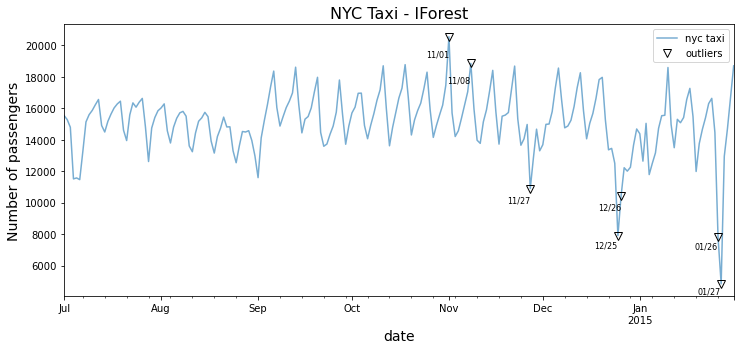

In [50]:
plot_outliers(outliers, 
              tx, 
              'IForest',
              labels=True)

In [51]:
iforest.threshold_

-7.945033519973776e-16

In [320]:
outliers

,value
timestamp,
2014-11-01,20553.500000
2014-11-08,18857.333333
2014-11-27,10899.666667
2014-12-25,7902.125000
2014-12-26,10397.958333
2015-01-26,7818.979167
2015-01-27,4834.541667


In [319]:
iforest_scores = iforest.decision_scores_
iforest_scores_df = (pd.DataFrame(iforest_scores, 
             index=tx.index, 
             columns=['score']))
iforest_scores_df[iforest_scores_df['score'] >= iforest.threshold_].sort_values('score', ascending=False)

,score
timestamp,
2015-01-27,0.238839
2014-11-01,0.206984
2014-12-25,0.138472
2015-01-26,0.138472
2014-12-26,0.100844
2014-11-27,0.042683
2014-11-08,0.018728


## There is more

In [222]:
import sklearn
sklearn.__version__

'1.0.2'

In [223]:
from sklearn.ensemble import IsolationForest

In [224]:
sk_iforest = IsolationForest(contamination=0.03)
sk_prediction = pd.Series(sk_iforest.fit_predict(tx), 
                      index=tx.index)
sk_outliers = sk_prediction[sk_prediction == -1]
sk_outliers = tx.loc[sk_outliers.index] 
sk_outliers

,value
timestamp,
2014-11-01,20553.500000
2014-11-08,18857.333333
2014-11-27,10899.666667
2014-12-25,7902.125000
2014-12-26,10397.958333
2015-01-26,7818.979167
2015-01-27,4834.541667


# Detecing Outliers using Copula-Based Outlier Detection (COPOD)

In [64]:
from pyod.models.copod import COPOD

In [65]:
copod = COPOD(contamination=0.03)
copod.fit(tx)

COPOD(contamination=0.03, n_jobs=1)

In [66]:
predicted = pd.Series(copod.predict(tx), 
                      index=tx.index)

In [67]:
print('Number of outliers = ', predicted.sum())

Number of outliers =  7


In [68]:
outliers = predicted[predicted == 1]
outliers = tx.loc[outliers.index] 
outliers

,value
timestamp,
2014-07-04,11511.770833
2014-07-06,11464.270833
2014-11-27,10899.666667
2014-12-25,7902.125000
2014-12-26,10397.958333
2015-01-26,7818.979167
2015-01-27,4834.541667


In [69]:
known_outliers

,value
timestamp,
2014-11-01,20553.500000
2014-11-27,10899.666667
2014-12-25,7902.125000
2015-01-01,14383.479167
2015-01-27,4834.541667


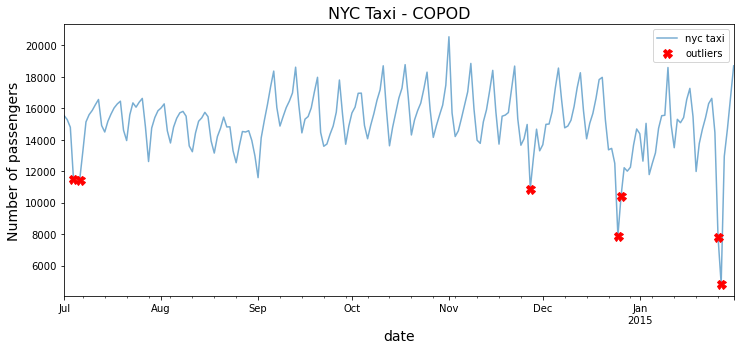

In [70]:
plot_outliers(outliers, tx, 'COPOD', name='fig14.10')

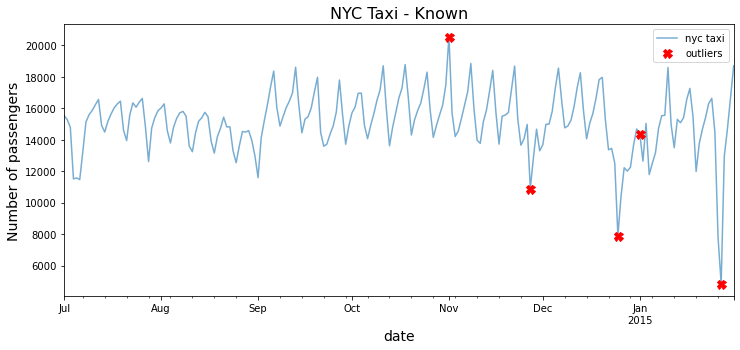

In [71]:
plot_outliers(known_outliers, tx, 'Known')

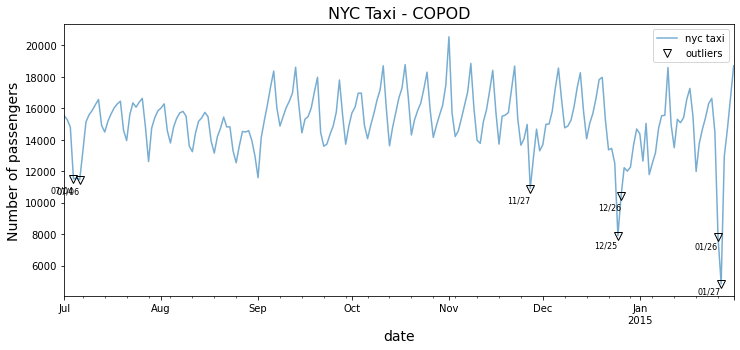

In [72]:
plot_outliers(outliers, 
              tx, 
              'COPOD',
              labels=True)

## There is more

In [559]:
from pyod.models.mad import MAD

In [569]:
mad = MAD(threshold=3)

In [578]:
predicted = pd.Series(mad.fit_predict(tx), 
                      index=tx.index)
outliers = predicted[predicted == 1]
outliers = tx.loc[outliers.index] 

In [579]:
outliers

,value
timestamp,
2014-11-01,20553.500000
2014-11-27,10899.666667
2014-12-25,7902.125000
2014-12-26,10397.958333
2015-01-26,7818.979167
2015-01-27,4834.541667


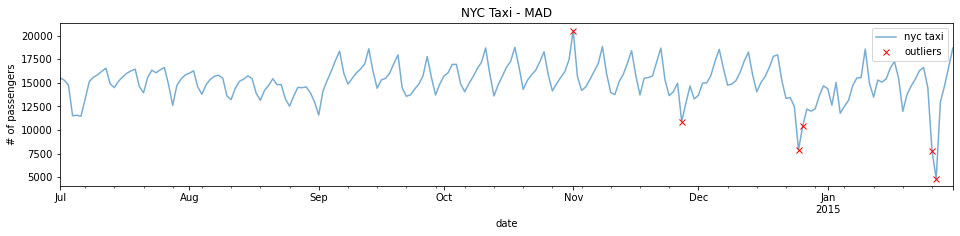

In [580]:
plot_outliers(outliers, tx, 'MAD')

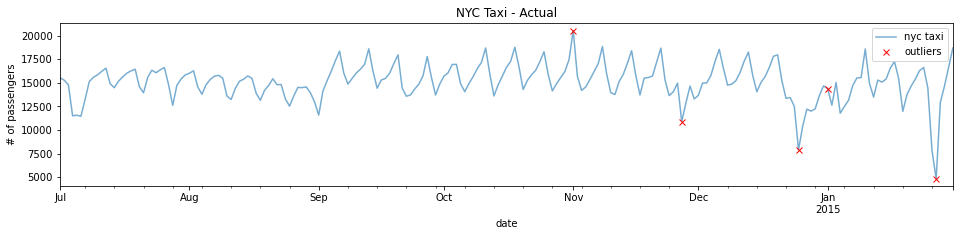

In [568]:
plot_outliers(known_outliers, tx, 'Known')

In [219]:
from pyod.models.loda import LODA

In [236]:
loda = LODA(contamination=0.03)
loda.fit(tx)

LODA(contamination=0.03, n_bins=10, n_random_cuts=100)

In [237]:
predicted = pd.Series(loda.predict(tx), 
                      index=tx.index)

In [238]:
print('Number of outliers = ', predicted.sum())

Number of outliers =  6


In [239]:
outliers = predicted[predicted == 1]
outliers = tx.loc[outliers.index] 
outliers

,value
timestamp,
2014-11-01,20553.500000
2014-11-27,10899.666667
2014-12-25,7902.125000
2014-12-26,10397.958333
2015-01-26,7818.979167
2015-01-27,4834.541667


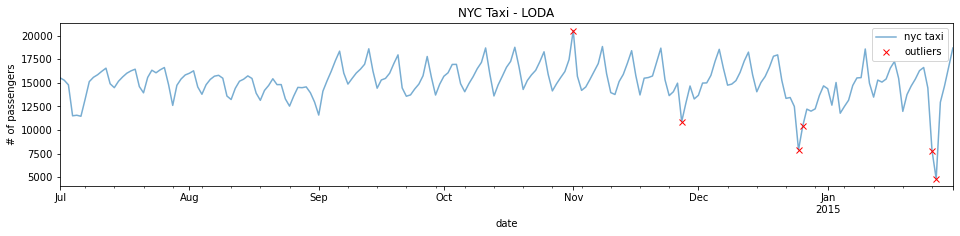

In [240]:
plot_outliers(outliers, tx, 'LODA')

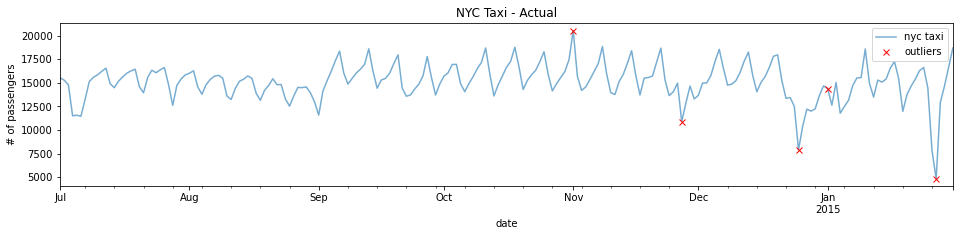

In [241]:
plot_outliers(known_outliers, tx, 'Known')

# Detecting Outliers using One Class SVM

In [52]:
from pyod.models.ocsvm import OCSVM

In [53]:
ocsvm = OCSVM(contamination=0.03, kernel='rbf')
ocsvm.fit(tx)

OCSVM(cache_size=200, coef0=0.0, contamination=0.03, degree=3, gamma='auto',
   kernel='rbf', max_iter=-1, nu=0.5, shrinking=True, tol=0.001,
   verbose=False)

In [54]:
predicted = pd.Series(ocsvm.predict(tx), 
                      index=tx.index)

In [55]:
print('Number of outliers = ', predicted.sum())

Number of outliers =  5


In [56]:
outliers = predicted[predicted == 1]
outliers = tx.loc[outliers.index] 
outliers

,value
timestamp,
2014-08-09,15499.708333
2014-11-18,15499.437500
2014-11-27,10899.666667
2014-12-24,12502.000000
2015-01-05,12502.750000


In [57]:
known_outliers

,value
timestamp,
2014-11-01,20553.500000
2014-11-27,10899.666667
2014-12-25,7902.125000
2015-01-01,14383.479167
2015-01-27,4834.541667


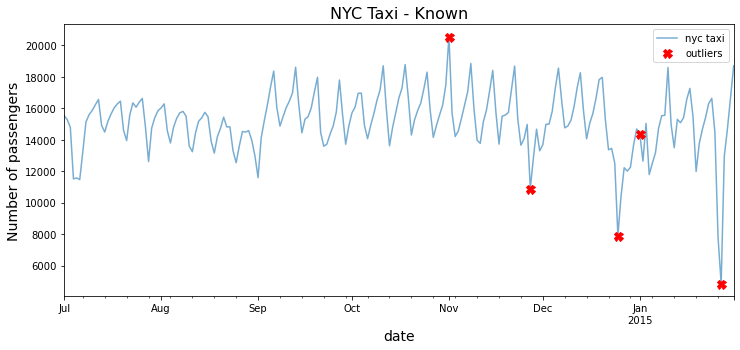

In [58]:
plot_outliers(known_outliers, tx, 'Known')

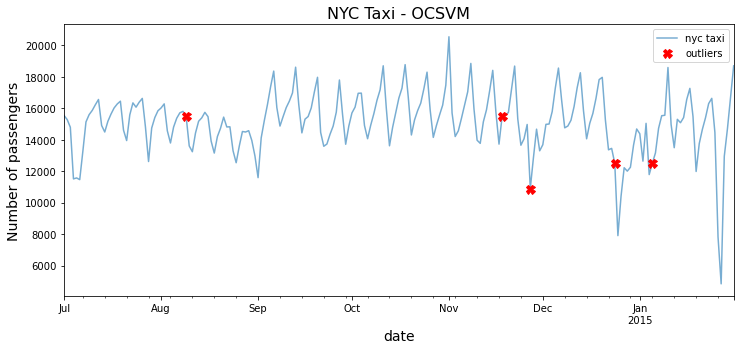

In [59]:
plot_outliers(outliers, tx, 'OCSVM', name='fig14.7')

In [61]:
from pyod.utils.utility import standardizer
scaled = standardizer(tx)
predicted = pd.Series(ocsvm.fit_predict(scaled), 
                      index=tx.index)
outliers = predicted[predicted == 1]
outliers = tx.loc[outliers.index] 
outliers

,value
timestamp,
2014-07-06,11464.270833
2014-11-01,20553.500000
2014-11-27,10899.666667
2014-12-25,7902.125000
2014-12-26,10397.958333
2015-01-26,7818.979167
2015-01-27,4834.541667


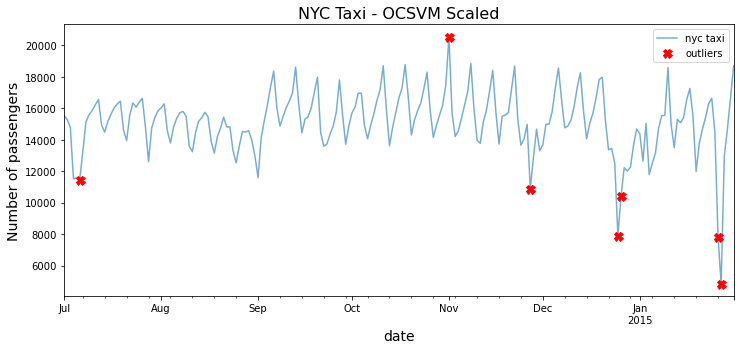

In [62]:
plot_outliers(outliers, tx, 'OCSVM Scaled', name='fig14.8')

## There is more

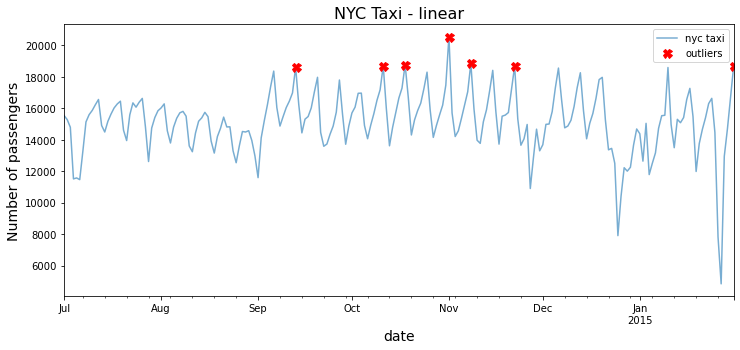

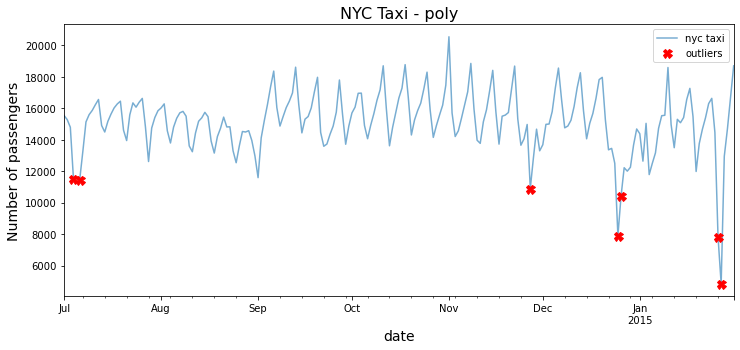

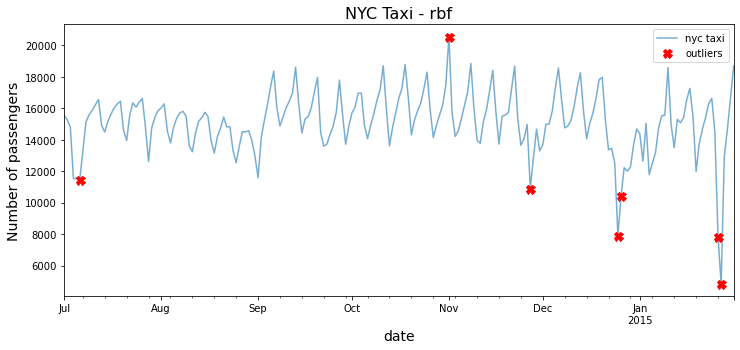

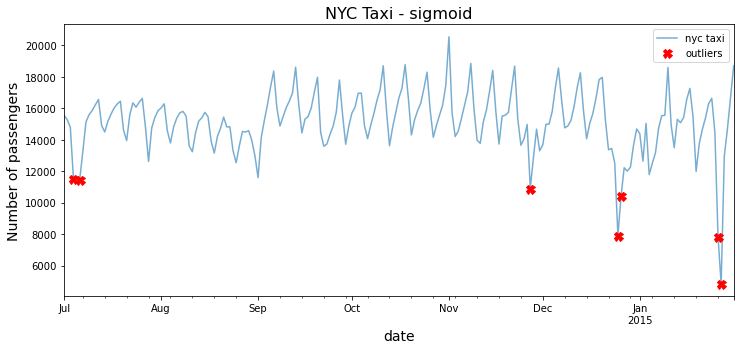

In [63]:
for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
    ocsvm = OCSVM(contamination=0.03, kernel=kernel)
    predict = pd.Series(ocsvm.fit_predict(scaled), 
                      index=tx.index, name=kernel)
    outliers = predict[predict == 1]
    outliers = tx.loc[outliers.index]
    plot_outliers(outliers, tx, kernel)
    